In [1]:
using Pkg
using SSM
using Random
using Distributions
using LinearAlgebra
using Plots
using ForwardDiff

In [2]:
# create a PLDS model
Random.seed!(123)

x0 = [0.0, 0.0]
P0 = Diagonal([1.0, 1.0])

A = [cos(0.25) -sin(0.25); sin(0.25) cos(0.25)]
Q = Diagonal([0.1, 0.1])

C = [0.5 0.5; 0.5 0.1; 0.1 0.1]

d = [3, 3, 3]
D = Diagonal([0, 0, 0])


T = 3

x = zeros(T, 2)
λ = zeros(T, 3)
y = zeros(T, 3)
b = ones(T, 2) * 0.1

x[1, :] = x0 + sqrt.(diag(P0)) .* randn(2)
λ[1, :] = exp.(C*x[1, :] + d)
y[1, :] = rand.(Poisson.(λ[1, :]))

for t in 2:T
    s = y[t-1, :] # assuming window is 1
    x[t, :] = A*x[t-1, :] + b[t-1, :] + sqrt.(diag(Q)).*randn(2)
    λ[t, :] = exp.(C*x[t, :] + d + D*s)
    y[t, :] = rand.(Poisson.(λ[t, :]))
end



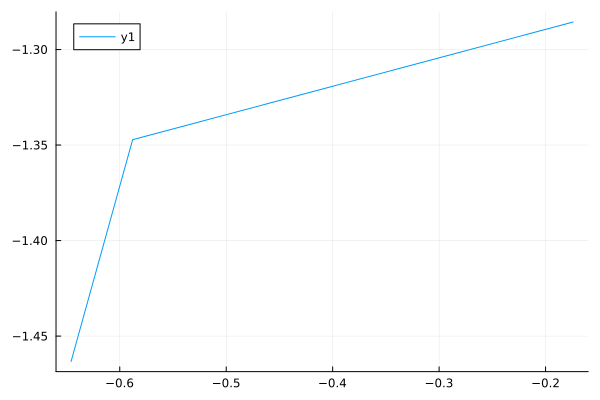

In [3]:
plot(x[:, 1], x[:, 2])

In [4]:
plds = SSM.PoissonLDS(;A=A, Q=Q, C=C, d=d, D=D, x0=x0, p0=P0, refractory_period=1, obs_dim=3, latent_dim=2, fit_bool=[true, true, true, true, true])

PoissonLDS([0.9689124217106447 -0.24740395925452294; 0.24740395925452294 0.9689124217106447], [0.5 0.5; 0.5 0.1; 0.1 0.1], [0.1 0.0; 0.0 0.1], [0 0 0; 0 0 0; 0 0 0], [3, 3, 3], Matrix{Float64}(undef, 0, 2), [0.0, 0.0], [1.0 0.0; 0.0 1.0], 1, 3, 2, Bool[1, 1, 1, 1, 1])

In [5]:
SSM.logposterior(x, plds, y, ones(T, 2)*0.1)

156.78880917183636

In [14]:
function logposterior(x::AbstractArray, plds::PoissonLDS, y::Matrix{<:Real}, b::Matrix{<:Real})
    T = size(y, 1)
    dim = plds.latent_dim
    x = SSM.interleave_reshape(x, T, dim)
    # Calculate the log-posterior
    T = size(y, 1)
    # Get an array of prior spikes
    s = SSM.countspikes(y, plds.refractory_period)
    # calculate the first term
    pygivenx = 0.0
    for t in 1:T
        pygivenx += (y[t, :]' * (plds.C * x[t, :] + plds.D * s[t, :] + plds.d)) - sum(exp.(plds.C * x[t, :] + plds.D * s[t, :] + plds.d))
    end
    # calculate the second term
    px1 =-0.5 * (x[1, :] - plds.x0)' * pinv(plds.p0) * (x[1, :] - plds.x0)
    # calculate the last term
    pxtgivenxt1 = 0.0
    for t in 2:T
        pxtgivenxt1 += -0.5 * (x[t, :] - ((plds.A * x[t-1, :]) - b[t-1, :]))' * pinv(plds.Q) * (x[t, :] - ((plds.A * x[t-1, :]) - b[t-1, :])) 
    end
    # sum the terms
    return pygivenx + px1 + pxtgivenxt1
end

obj(x) = x -> logposterior(x, plds, y, b)
 
autograd = ForwardDiff.hessian(obj(x), reshape(x', 6, 1))


6×6 Matrix{Float64}:
 -16.0529    -2.54015    9.68912    2.47404    0.0        0.0
  -2.54015  -13.0376    -2.47404    9.68912    0.0        0.0
   9.68912   -2.47404  -25.3445    -2.72789    9.68912    2.47404
   2.47404    9.68912   -2.72789  -22.2046    -2.47404    9.68912
   0.0        0.0        9.68912   -2.47404  -16.6413    -3.40331
   0.0        0.0        2.47404    9.68912   -3.40331  -12.7557

In [13]:
hess = SSM.Hessian(x, plds, y)[1]

6×6 Matrix{Float64}:
 -16.0529    -2.54015    9.68912    2.47404    0.0        0.0
  -2.54015  -13.0376    -2.47404    9.68912    0.0        0.0
   9.68912   -2.47404  -25.3445    -2.72789    9.68912    2.47404
   2.47404    9.68912   -2.72789  -22.2046    -2.47404    9.68912
   0.0        0.0        9.68912   -2.47404  -16.6413    -3.40331
   0.0        0.0        2.47404    9.68912   -3.40331  -12.7557

In [8]:
function calculatepoissonhess(C::Matrix{<:Real}, λ::Vector{<:Real})
    hess = zeros(size(C, 2), size(C, 2))
    for i in 1:size(C, 1)
        hess -= λ[i] * C[i, :] * C[i, :]'
    end
    return hess
end


function Hessian(x::Matrix{<:Real}, plds::PoissonLDS, y::Matrix{<:Real})
    # pre-compute a few things
    T = size(y, 1)
    inv_Q = pinv(plds.Q)
    inv_p0 = pinv(plds.p0)
    s = SSM.countspikes(y, plds.refractory_period)

    # calculate super and sub diagonals
    H_sub_entry = inv_Q * plds.A
    H_super_entry = Matrix(H_sub_entry')
 
    H_sub = Vector{typeof(H_sub_entry)}(undef, T-1)
    H_super = Vector{typeof(H_super_entry)}(undef, T-1)
 
    Threads.@threads for i in 1:T-1
        H_sub[i] = H_sub_entry
        H_super[i] = H_super_entry
    end
     
     # pre-compute common terms
    xt_given_xt_1 = - inv_Q
    xt1_given_xt = - plds.A' * inv_Q * plds.A
    xt = - inv_p0

    # calculate the main diagonal
    main = Vector{typeof(xt1_given_xt)}(undef, T)

    for t in 1:T
        λ = exp.(plds.C * x[t, :] + plds.D * s[t, :] + plds.d)
        if t == 1
            main[t] = xt + xt1_given_xt + calculatepoissonhess(plds.C, λ)
        elseif t == T
            main[t] = xt_given_xt_1 + calculatepoissonhess(plds.C, λ)
        else
            main[t] = xt_given_xt_1 + xt1_given_xt + calculatepoissonhess(plds.C, λ)
        end
    end
    return Matrix(block_tridgm(main, H_super, H_sub)), main, H_super, H_sub
end

hess, main, H_super, H_sub = Hessian(x, plds, y)

([-16.052880272434834 -2.5401457441369795 … 0.0 0.0; -2.5401457441369804 -13.03759883847741 … 0.0 0.0; … ; 0.0 0.0 … -16.641302204948975 -3.403308893532166; 0.0 0.0 … -3.403308893532166 -12.755710231248804], [[-16.052880272434834 -2.5401457441369795; -2.5401457441369804 -13.03759883847741], [-25.34454456493362 -2.727892356348564; -2.727892356348565 -22.204561914631554], [-16.641302204948975 -3.403308893532166; -3.403308893532166 -12.755710231248804]], [[9.689124217106448 2.474039592545229; -2.474039592545229 9.689124217106448], [9.689124217106448 2.474039592545229; -2.474039592545229 9.689124217106448]], [[9.689124217106448 -2.474039592545229; 2.474039592545229 9.689124217106448], [9.689124217106448 -2.474039592545229; 2.474039592545229 9.689124217106448]])

In [9]:
hess

6×6 Matrix{Float64}:
 -16.0529    -2.54015    9.68912    2.47404    0.0        0.0
  -2.54015  -13.0376    -2.47404    9.68912    0.0        0.0
   9.68912   -2.47404  -25.3445    -2.72789    9.68912    2.47404
   2.47404    9.68912   -2.72789  -22.2046    -2.47404    9.68912
   0.0        0.0        9.68912   -2.47404  -16.6413    -3.40331
   0.0        0.0        2.47404    9.68912   -3.40331  -12.7557

In [10]:

main[1] = xt + xt1_given_xt - (plds.C' * sum(exp.(plds.C * x[1, :] + plds.D * s[1, :] + plds.d)) * plds.C)
# calcualte hessian for t=2 to t=t-1
for t in 2:T-1
    main[t] = xt_given_xt_1 + xt1_given_xt - (plds.C' * sum(exp.(plds.C * x[t, :] + plds.D * s[1, :] + plds.d)) * plds.C)
end
# calculate the last main diagonal
main[T] = xt_given_xt_1 - (plds.C' * sum(exp.(plds.C * x[T, :] + plds.D * s[1, :] + plds.d)) * plds.C)  

UndefVarError: UndefVarError: `xt` not defined